# #PraTodosVerem - Anotação de Imagens com Categoria

Autor: Fabio Beranizo Fontes Lopes<br>
Email: fabio.beranizo@gmail.com

> Neste notebook propomos um processo para anotar as imagens com uma das 3 categorias propostas anteriormente (Foto; Arte; Heterogêneo).
> Uma vez anotados, podemos selecionar imagens de grupos e experimentar alguns baselines.

## Aprendizados

A solução com ResNet50 + Classificador SVM funciona bem e podemos adotá-la. :)

## Feature Extraction c/ ResNet50 + K-Means

In [15]:
import numpy as np
import tensorflow as tf
from IPython.display import Image, display
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

In [2]:
image_size = (224, 224)
input_shape = (*image_size, 3)
batch_size = 50

train_ds = tf.keras.utils.image_dataset_from_directory(
    "../data/raw/posts/",
    seed=0,
    image_size=image_size,
    batch_size=batch_size,
    label_mode="categorical",
    labels="inferred",
    shuffle=False,
    crop_to_aspect_ratio=True)

Found 861 files belonging to 206 classes.


2022-10-12 21:27:29.258878: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:04:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-10-12 21:27:29.280832: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.4/lib64:/usr/local/cuda-11.4/lib64/stubs:
2022-10-12 21:27:29.280849: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-10-12 21:27:29.281699: I tensorflow/core/platform/cpu_feature_guard.cc:193]

In [3]:
resnet = tf.keras.applications.ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)

In [4]:
mask_main_image = np.array([0 if "/0.jpg" in filepath else 1 for filepath in train_ds.file_paths])

In [5]:
filenames = np.array(train_ds.file_paths)[mask_main_image==0]

In [6]:
feature_extractor_model = tf.keras.Sequential([
    resnet,
    tf.keras.layers.GlobalAveragePooling2D()
])

X = feature_extractor_model.predict(train_ds)
X = X[mask_main_image==0]

18/18 [==============================] - 27s 1s/step


In [7]:
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

In [8]:
n_clusters = 3
kmeans = KMeans(n_clusters)
label = kmeans.fit_predict(X)

In [9]:
import pandas as pd
import plotly.express as px

df = pd.DataFrame({"x": X[:,0], "y": X[:,1], "color": label.astype(str), "filenames": filenames})

fig = px.scatter(df, x="x", y="y", color="color", hover_data=["filenames"])
fig.show()

### Resultados

In [10]:
import collections

counter = collections.Counter(label)
counter

Counter({0: 78, 1: 23, 2: 101})

In [67]:
n_images = 2

### Grupo 0

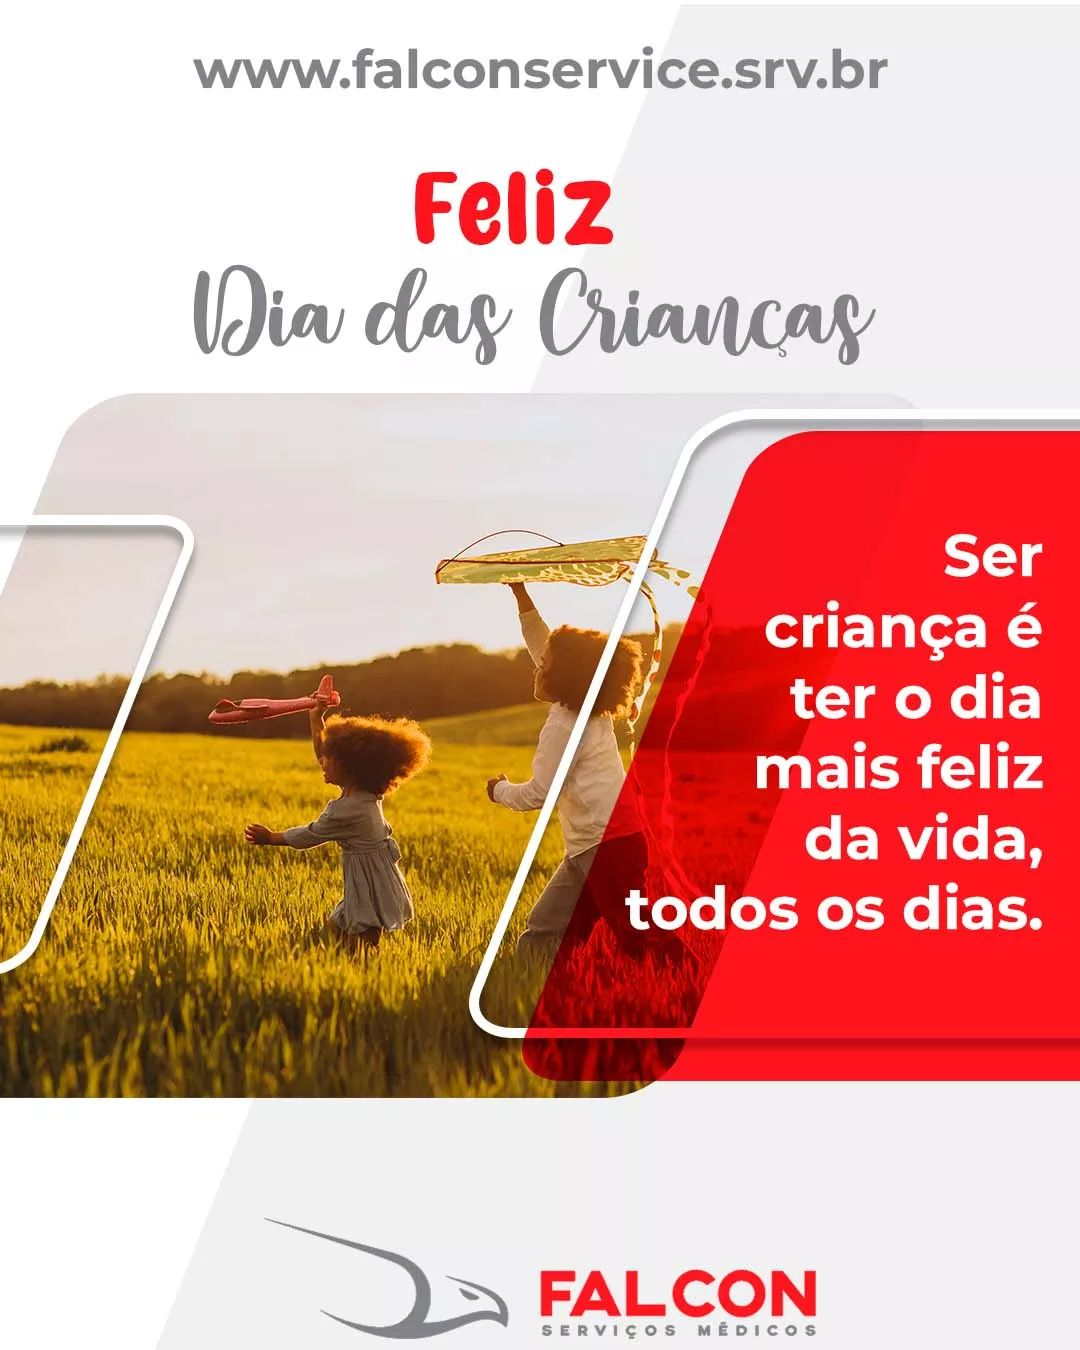

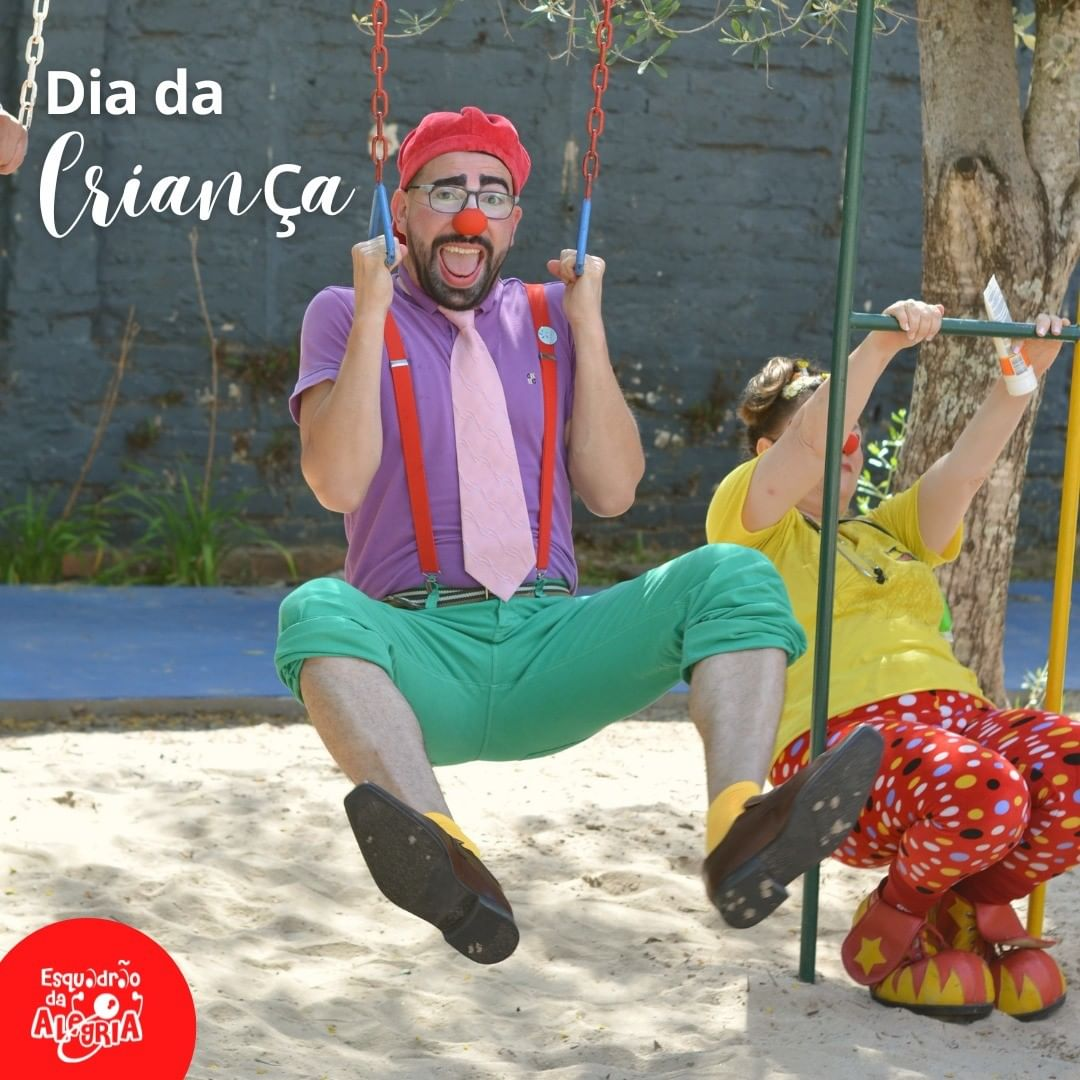

In [68]:
group = "0"
images = [Image(filename=image_path) for image_path in df.loc[df["color"]==group, "filenames"].sample(n_images, random_state=0)]
display(*images)

### Grupo 1

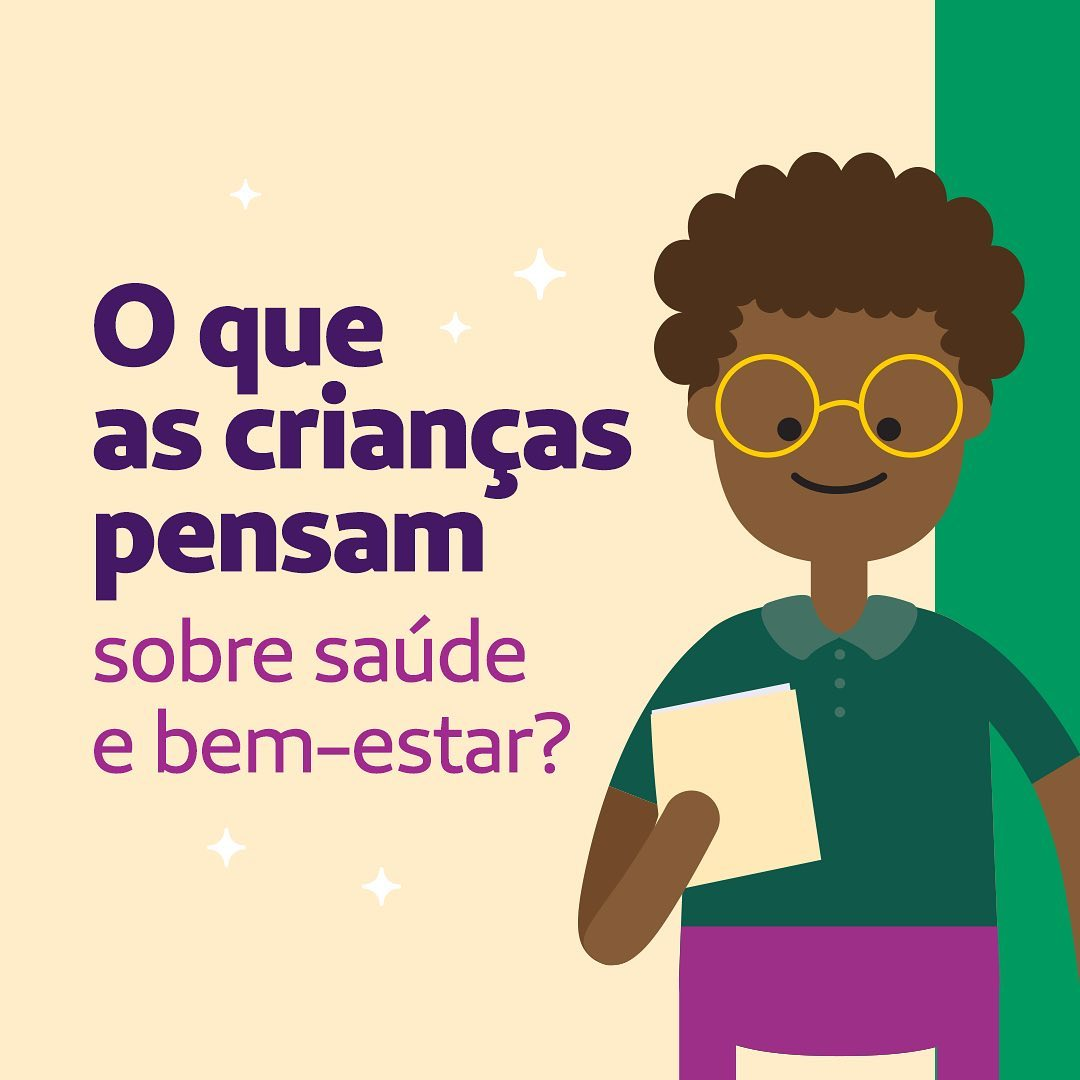

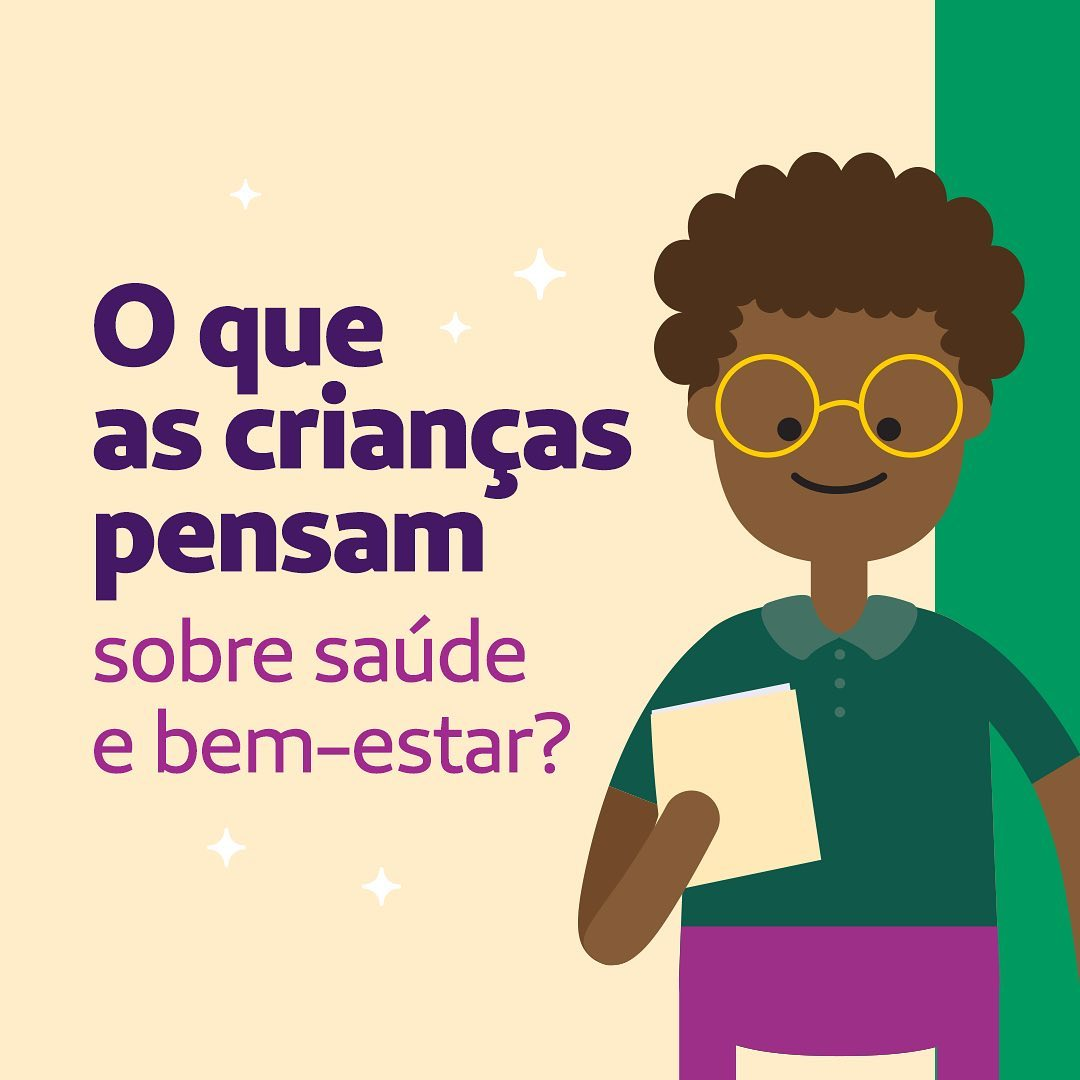

In [69]:
group = "1"
images = [Image(filename=image_path) for image_path in df.loc[df["color"]==group, "filenames"].sample(n_images, random_state=0)]
display(*images)

### Grupo 2

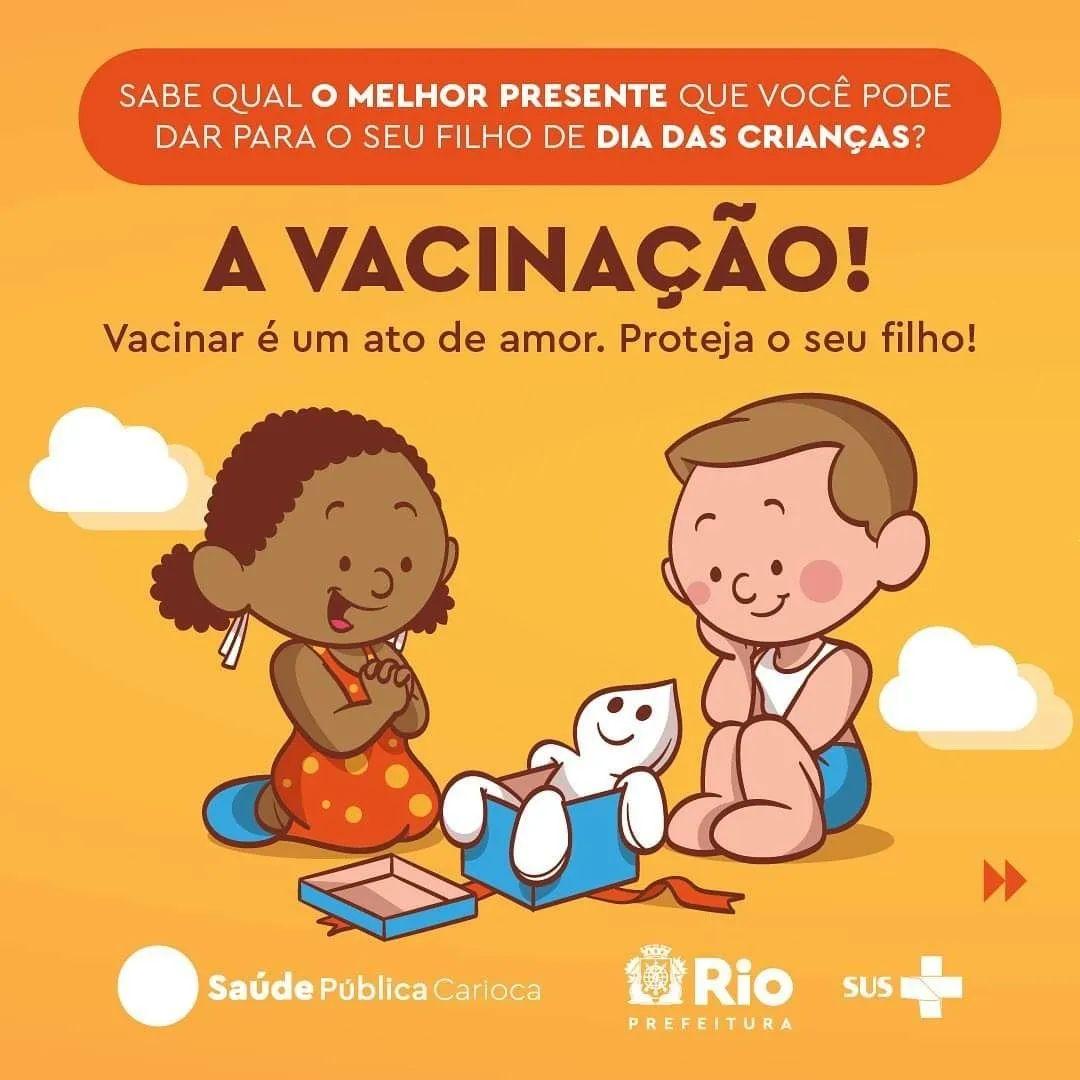

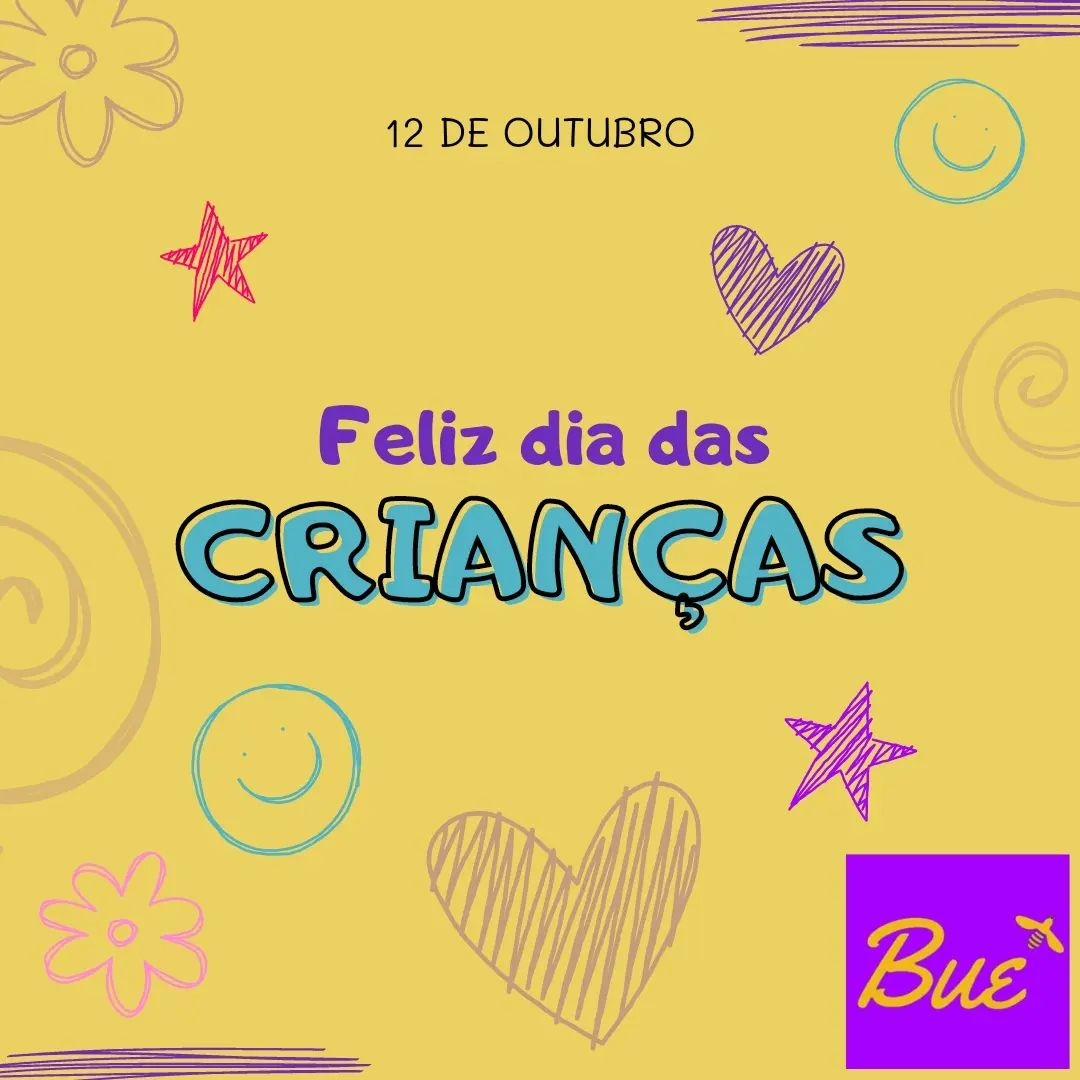

In [70]:
group = "2"
images = [Image(filename=image_path) for image_path in df.loc[df["color"]==group, "filenames"].sample(n_images, random_state=0)]
display(*images)

## Feature Extraction c/ ResNet50 + Classificador SVM

*Treinado com 40 imagens anotadas manualmente

In [72]:
# anotação manual
# 0 = foto, 1 = arte, 2 = mescla
y = np.array([
    0,0,0,0,1,0,2,1,1,0,0,0,2,1,1,2,2,1,2,0,1,1,2,2,1,2,2,2,1,1,2,1,1,0,0,0,2,1,2,1
])
y = np.concatenate((y, np.repeat(-1, X.shape[0] - y.shape[0])))

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=X.shape[0] - 40, shuffle=False)

svc = SVC()
svc.fit(X_train, y_train)

y_pred = svc.predict(X)

### Grupo 0 - Foto

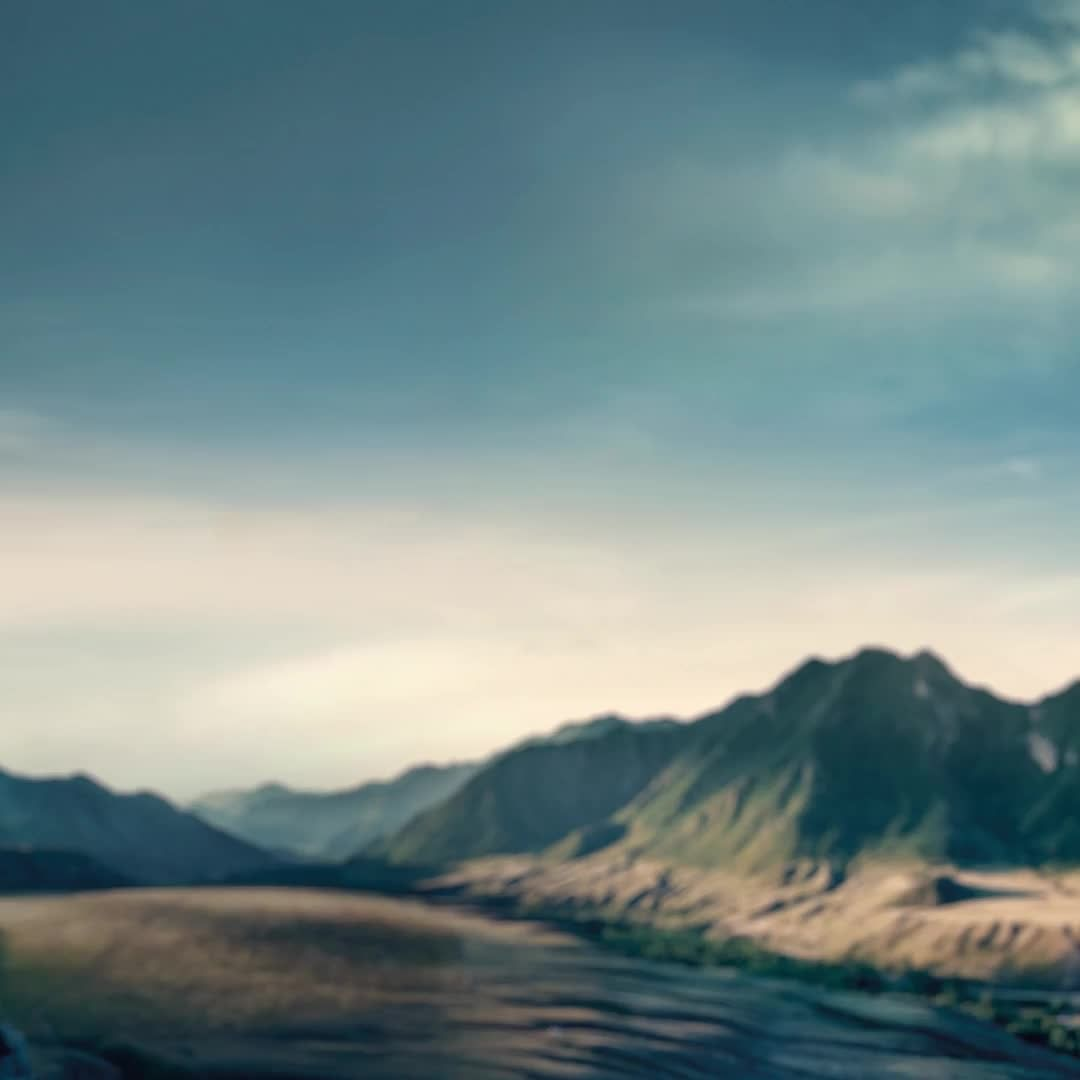

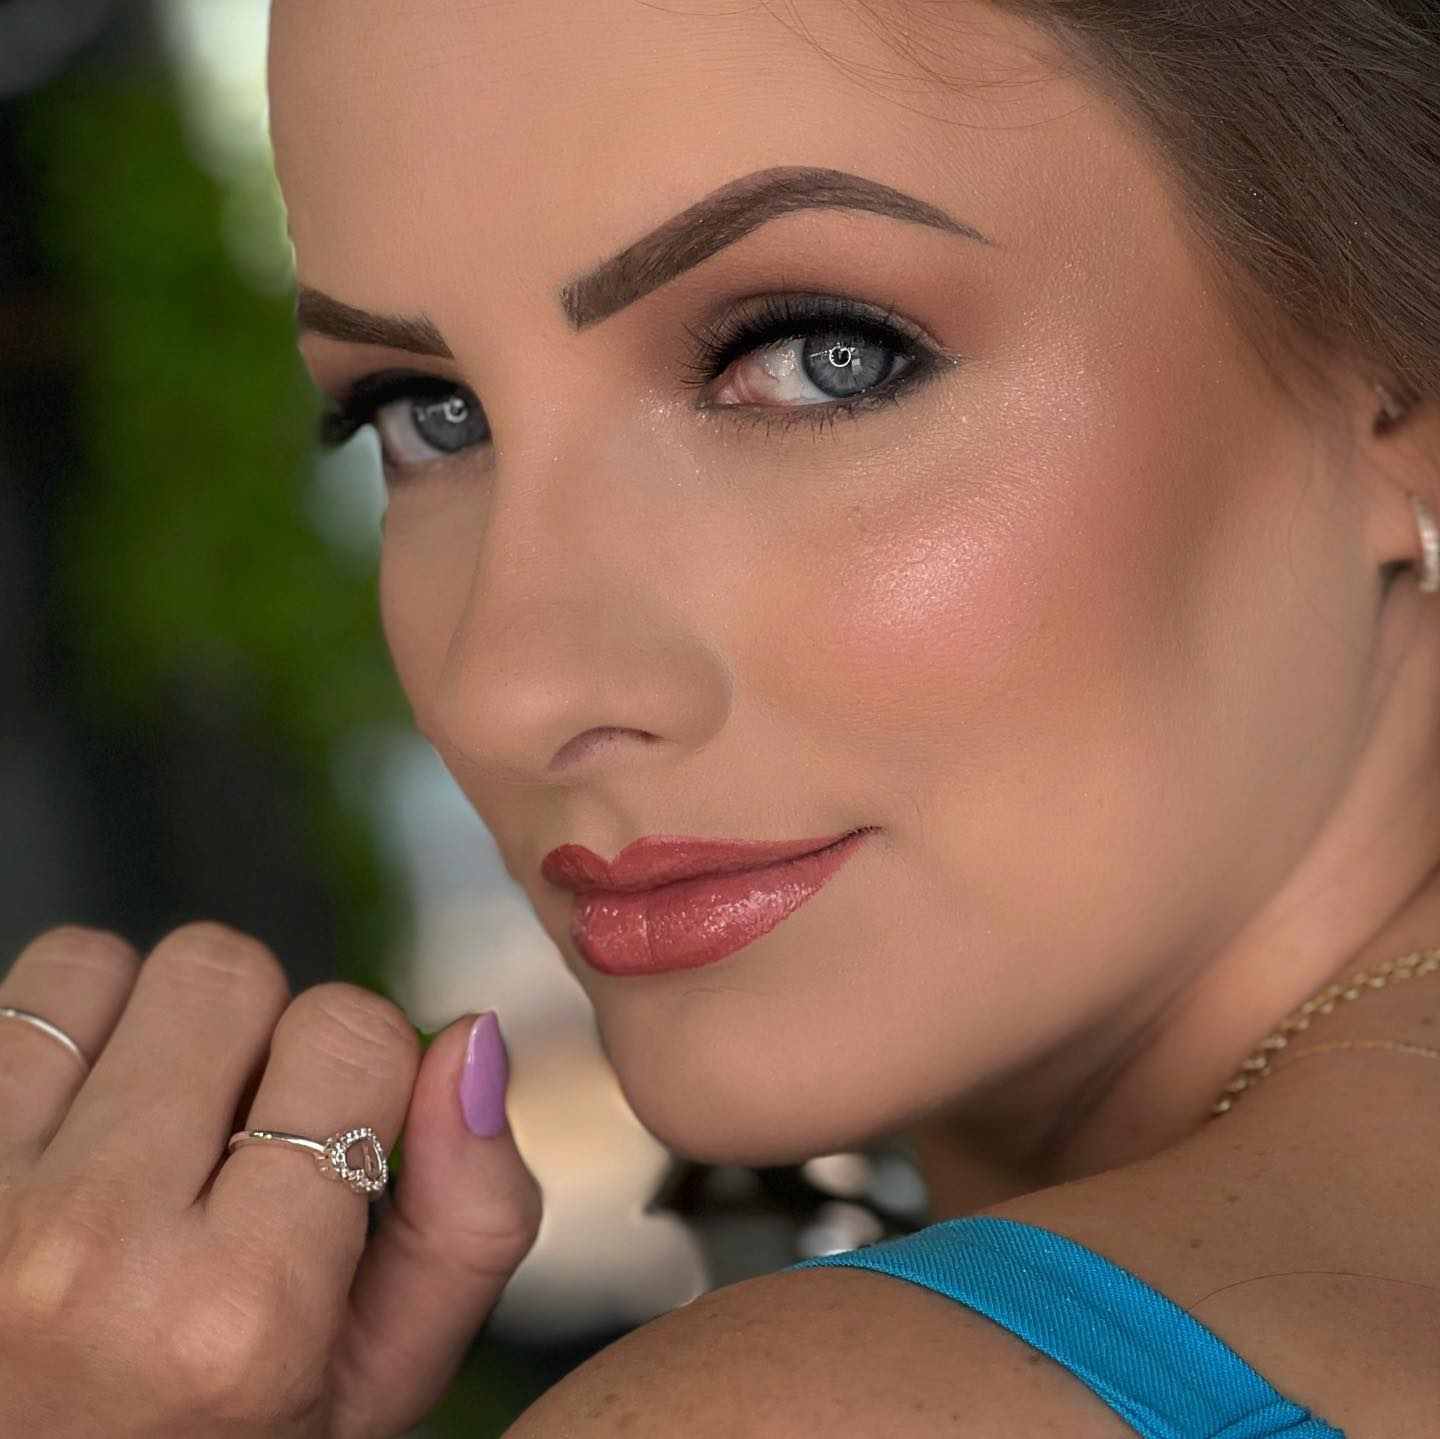

In [77]:
display(*[Image(filename=f) for f in filenames[y_pred==0][-2:]])

### Grupo 1 - Arte

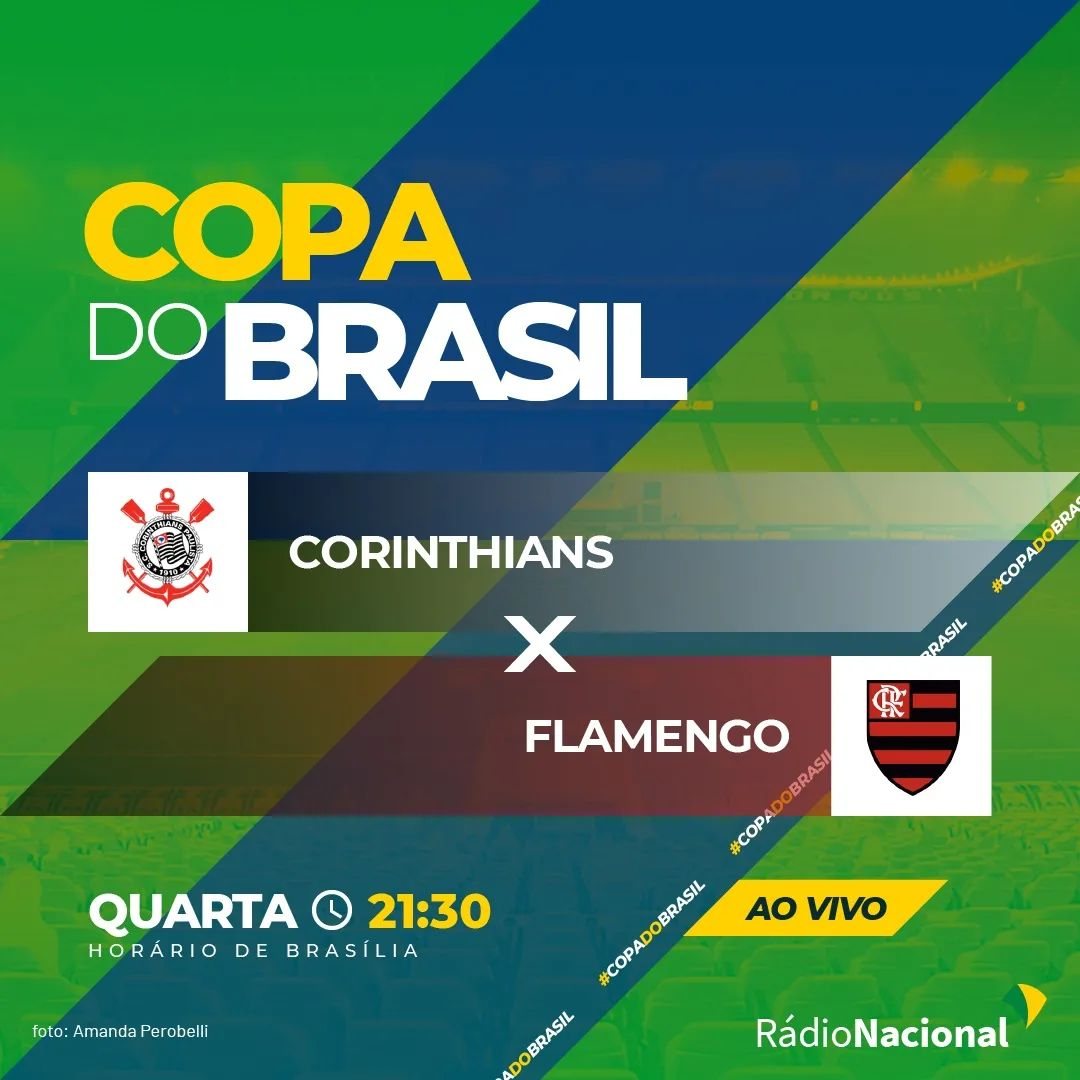

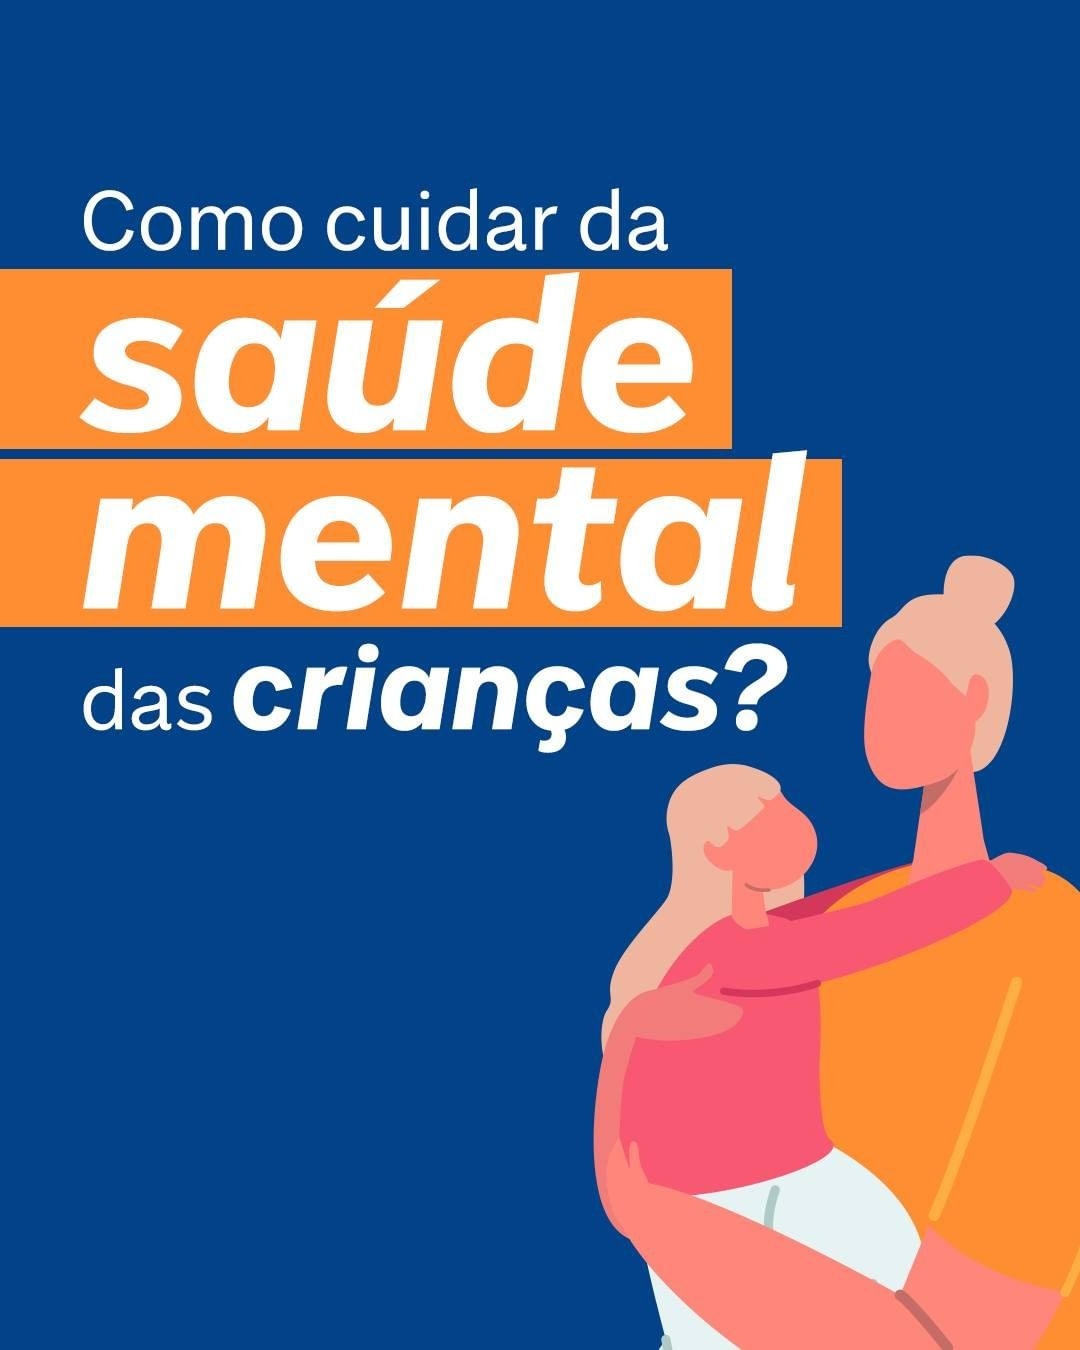

In [76]:
display(*[Image(filename=f) for f in filenames[y_pred==1][-2:]])

### Grupo 2 - Heterogêneo

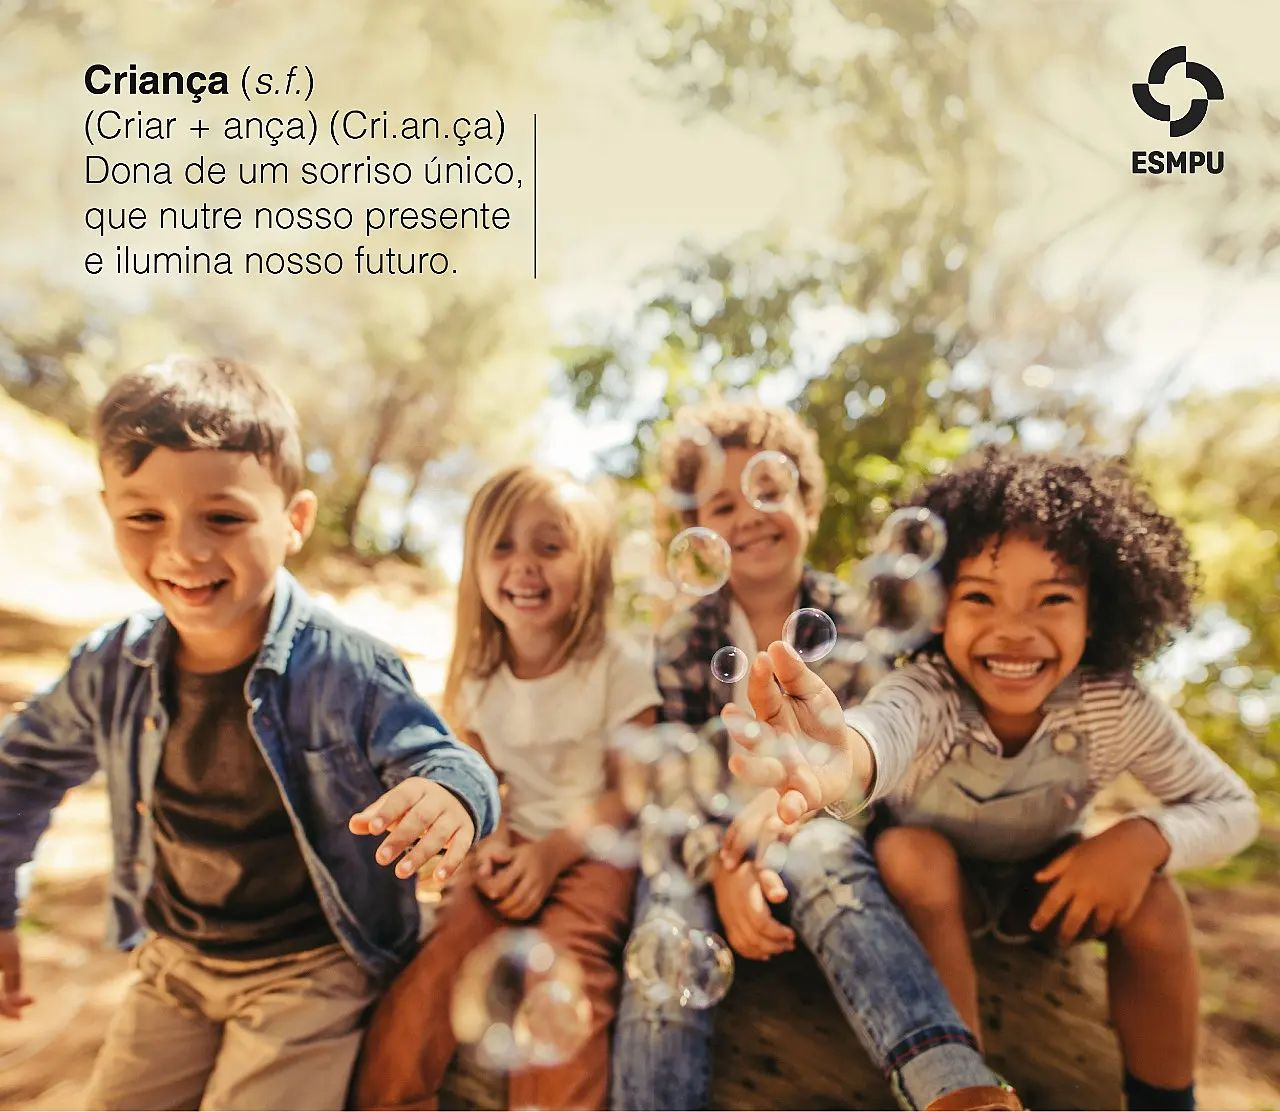

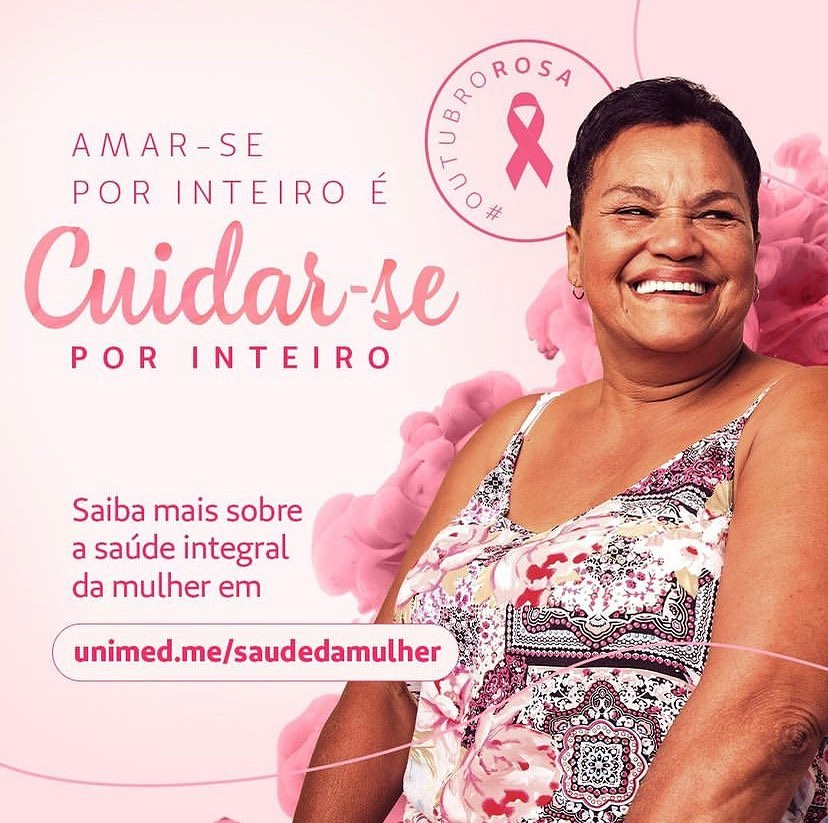

In [75]:
display(*[Image(filename=f) for f in filenames[y_pred==2][-2:]])